# Conditional DDPM for Strabismus Detection
## Binary Classification: Strabismus vs Normal

This notebook implements a Conditional Denoising Diffusion Probabilistic Model (DDPM) for generating eye images conditioned on class labels (Strabismus or Normal).

**Dataset Structure:**
- Normal: 105 images
- Strabismus: 209 images (4 subtypes combined)

**Hardware:**
- GPU: RTX A6000
- CUDA: 12.4
- Python: 3.11.14

## 1. Setup and Imports

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

# Wandb for experiment tracking
import wandb

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA RTX A6000
CUDA Version: 12.1
Available GPU Memory: 51.53 GB


## 2. Configuration

In [6]:
# Dataset Configuration
DATA_DIR = Path('../data')
IMG_SIZE = 128  # Proven to work well - faster training
BATCH_SIZE = 16  # Proven stable batch size
NUM_WORKERS = 0  # Windows compatibility

# Model Configuration
NUM_CLASSES = 2  # 0: Strabismus, 1: Normal
CHANNELS = 3
TIME_EMB_DIM = 256
CLASS_EMB_DIM = 128

# DDPM Configuration - Proven working parameters
TIMESTEPS = 1000  # Standard DDPM
BETA_START = 0.0001  # Standard: β1 = 1e-4
BETA_END = 0.02      # Standard: βT = 0.02

# Training Configuration - Proven optimal settings
EPOCHS = 500  # Sufficient for 128x128
LEARNING_RATE = 2e-4  # Proven learning rate for faster convergence
SAVE_EVERY = 50
SAMPLE_EVERY = 25
NUM_SAMPLES = 8

# EMA Configuration
EMA_DECAY = 0.9999  # Standard for datasets with hundreds of images

# Wandb Configuration
WANDB_PROJECT = "conditional-ddpm-strabismus"
WANDB_ENTITY = None
USE_WANDB = True

# Output directories
OUTPUT_DIR = Path('outputs')
CHECKPOINT_DIR = OUTPUT_DIR / 'checkpoints'
SAMPLE_DIR = OUTPUT_DIR / 'samples'
EVAL_DIR = OUTPUT_DIR / 'evaluation'

# Create directories
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
EVAL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration loaded - Back to proven 128x128 settings!")
print(f"")
print(f"Key parameters (from working commit 070b647):")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Timesteps: {TIMESTEPS}")
print(f"  EMA decay: {EMA_DECAY}")
print(f"")
print(f"Advantages of 128x128:")
print(f"  ✓ 4x fewer pixels than 256x256")
print(f"  ✓ Faster training (~50-60 sec/epoch vs 180-200 sec/epoch)")
print(f"  ✓ Proven to generate recognizable eye images")
print(f"  ✓ Lower memory usage")
print(f"")
print(f"Expected training time: ~6-8 hours for 500 epochs")

Configuration loaded - Back to proven 128x128 settings!

Key parameters (from working commit 070b647):
  Image size: 128x128
  Batch size: 16
  Learning rate: 0.0002
  Epochs: 500
  Timesteps: 1000
  EMA decay: 0.9999

Advantages of 128x128:
  ✓ 4x fewer pixels than 256x256
  ✓ Faster training (~50-60 sec/epoch vs 180-200 sec/epoch)
  ✓ Proven to generate recognizable eye images
  ✓ Lower memory usage

Expected training time: ~6-8 hours for 500 epochs


## 3. Dataset Preparation

In [7]:
class StrabismusDataset(Dataset):
    """
    Custom dataset for Strabismus vs Normal classification.
    Works with preprocessed dataset where all strabismus types are in one folder.
    Images are preprocessed to 256x256 and will be resized to target size.
    """
    def __init__(self, root_dir, img_size=128, transform=None):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.transform = transform
        
        # Load all image paths and labels
        self.data = []
        
        # Load strabismus images (class 0)
        strab_dir = self.root_dir / 'STRABISMUS'
        if strab_dir.exists():
            for img_path in strab_dir.glob('*.jpg'):
                self.data.append((img_path, 0))  # 0 = strabismus
        
        # Load normal images (class 1)
        normal_dir = self.root_dir / 'NORMAL'
        if normal_dir.exists():
            for img_path in normal_dir.glob('*.jpg'):
                self.data.append((img_path, 1))  # 1 = normal
        
        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),  # Resize from 256x256 to target
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
            ])
        
        print(f"Dataset loaded from: {self.root_dir}")
        print(f"  Total images: {len(self.data)}")
        strab_count = sum(1 for _, label in self.data if label == 0)
        normal_count = sum(1 for _, label in self.data if label == 1)
        print(f"  Strabismus: {strab_count}")
        print(f"  Normal: {normal_count}")
        print(f"  Images will be resized to {img_size}x{img_size}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create dataset and dataloader
dataset = StrabismusDataset(DATA_DIR, img_size=IMG_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader created with {len(dataloader)} batches")
print(f"Note: NUM_WORKERS={NUM_WORKERS} prevents multiprocessing errors on Windows")

Dataset loaded from: ..\data
  Total images: 314
  Strabismus: 209
  Normal: 105
  Images will be resized to 128x128

DataLoader created with 20 batches
Note: NUM_WORKERS=0 prevents multiprocessing errors on Windows


## 4. Visualize Dataset Samples

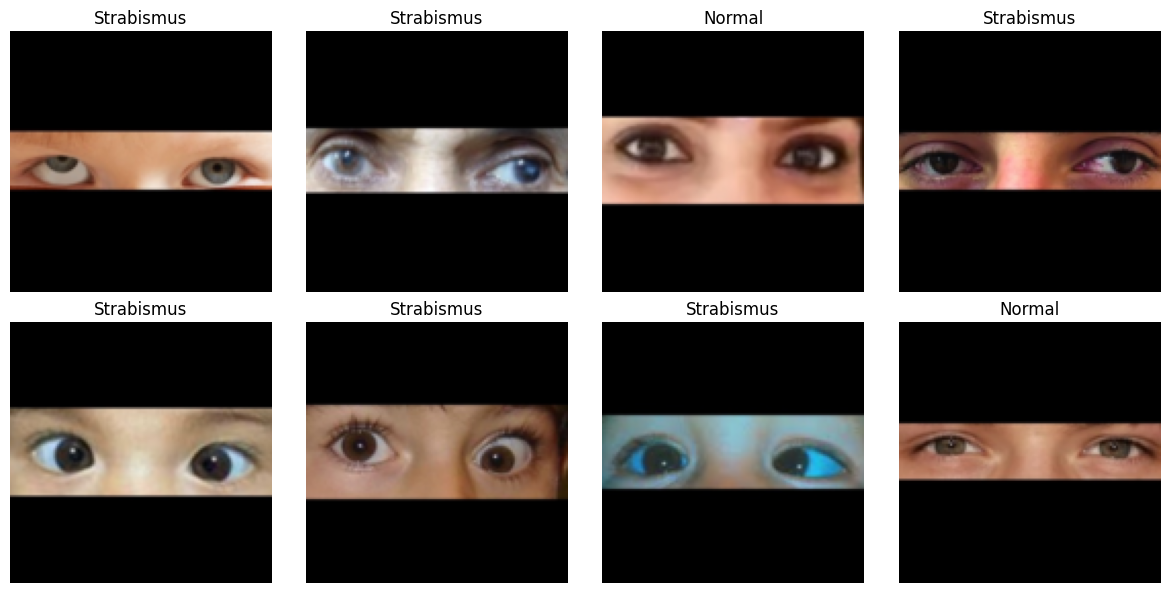

In [8]:
def show_images(images, labels, num_samples=8):
    """Visualize a batch of images with their labels"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    class_names = ['Strabismus', 'Normal']
    
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{class_names[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
sample_images, sample_labels = next(iter(dataloader))
show_images(sample_images, sample_labels)

## 5. DDPM Noise Scheduler

In [9]:
class DDPMScheduler:
    """
    Implements the noise schedule and sampling for DDPM.
    """
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, schedule='linear', device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.schedule = schedule

        if schedule == 'linear':
            # Linear beta schedule
            betas = torch.linspace(beta_start, beta_end, timesteps, device=device, dtype=torch.float32)
        elif schedule == 'cosine':
            # Cosine schedule from Nichol & Dhariwal 2021
            s = 0.008
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps, device=device, dtype=torch.float32)
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi / 2) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            betas = torch.clamp(betas, min=1e-5, max=0.999)
        else:
            raise ValueError(f"Unsupported beta schedule: {schedule}")

        self.betas = betas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )

    def add_noise(self, x_start, t, noise=None):
        """
        Add noise to the input image according to timestep t.
        q(x_t | x_0)
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def sample_prev_timestep(self, x_t, t, predicted_noise):
        """
        Sample x_{t-1} given x_t and predicted noise.
        p(x_{t-1} | x_t)
        """
        # Get coefficients
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].reshape(-1, 1, 1, 1)
        betas_t = self.betas[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        # Predict x_0
        model_mean = sqrt_recip_alphas_t * (
            x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
        )

        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self.posterior_variance[t].reshape(-1, 1, 1, 1)
            noise = torch.randn_like(x_t)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

# Initialize scheduler with linear schedule (proven to work)
scheduler = DDPMScheduler(
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    device=device
)

print(f"DDPM Scheduler initialized:")
print(f"  Timesteps: {TIMESTEPS}")
print(f"  Beta range: [{BETA_START}, {BETA_END}]")

DDPM Scheduler initialized:
  Timesteps: 1000
  Beta range: [0.0001, 0.02]


## 6. U-Net Model with Class Conditioning

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResidualBlock(nn.Module):
    """Residual block with group normalization and time/class embedding"""
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        
        # Time and class embedding projection
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_emb_dim, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb, class_emb):
        h = self.conv1(x)
        
        # Add time and class embeddings
        h = h + self.time_emb(time_emb)[:, :, None, None]
        h = h + self.class_emb(class_emb)[:, :, None, None]
        
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    """Self-attention block"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
    
    def forward(self, x):
        b, c, h, w = x.shape
        
        # Normalize and compute Q, K, V
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for multi-head attention
        q = q.view(b, self.num_heads, c // self.num_heads, h * w).transpose(-1, -2)
        k = k.view(b, self.num_heads, c // self.num_heads, h * w)
        v = v.view(b, self.num_heads, c // self.num_heads, h * w).transpose(-1, -2)
        
        # Attention
        attn = torch.softmax(q @ k / np.sqrt(c // self.num_heads), dim=-1)
        out = (attn @ v).transpose(-1, -2).reshape(b, c, h, w)
        
        return x + self.proj(out)


class ConditionalUNet(nn.Module):
    """
    U-Net with time and class conditioning for DDPM.
    Optimized for 128x128 images with efficient attention.
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        num_classes=2,
        base_channels=64,
        channel_mults=(1, 2, 4, 8),
        time_emb_dim=256,
        class_emb_dim=128,
        num_res_blocks=2,
        use_attention=(False, True, True, True)  # Attention at 64x64, 32x32, 16x16
    ):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Class embedding
        self.class_emb = nn.Embedding(num_classes, class_emb_dim)
        
        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        # Build encoder
        self.encoder = nn.ModuleList()
        channels = [base_channels]
        now_channels = base_channels
        
        for i, mult in enumerate(channel_mults):
            out_channels_layer = base_channels * mult
            
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(now_channels, out_channels_layer, time_emb_dim, class_emb_dim)]
                now_channels = out_channels_layer
                
                if use_attention[i]:
                    layers.append(AttentionBlock(now_channels))
                
                self.encoder.append(nn.ModuleList(layers))
                channels.append(now_channels)
            
            if i != len(channel_mults) - 1:
                # Downsample
                self.encoder.append(nn.ModuleList([nn.Conv2d(now_channels, now_channels, 3, stride=2, padding=1)]))
                channels.append(now_channels)
        
        # Middle
        self.middle = nn.ModuleList([
            ResidualBlock(now_channels, now_channels, time_emb_dim, class_emb_dim),
            AttentionBlock(now_channels),
            ResidualBlock(now_channels, now_channels, time_emb_dim, class_emb_dim)
        ])
        
        # Build decoder
        self.decoder = nn.ModuleList()
        
        for i, mult in reversed(list(enumerate(channel_mults))):
            out_channels_layer = base_channels * mult
            
            for j in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        now_channels + channels.pop(),
                        out_channels_layer,
                        time_emb_dim,
                        class_emb_dim
                    )
                ]
                now_channels = out_channels_layer
                
                if use_attention[i]:
                    layers.append(AttentionBlock(now_channels))
                
                self.decoder.append(nn.ModuleList(layers))
            
            if i != 0:
                # Upsample
                self.decoder.append(nn.ModuleList([
                    nn.ConvTranspose2d(now_channels, now_channels, 4, stride=2, padding=1)
                ]))
        
        # Output
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, now_channels),
            nn.SiLU(),
            nn.Conv2d(now_channels, out_channels, 3, padding=1)
        )
    
    def forward(self, x, t, y):
        """
        Args:
            x: Input image [B, C, H, W]
            t: Timestep [B]
            y: Class label [B]
        """
        # Embed time and class
        time_emb = self.time_mlp(t)
        class_emb = self.class_emb(y)
        
        # Initial conv
        h = self.conv_in(x)
        
        # Encoder
        skips = [h]
        for module_list in self.encoder:
            for layer in module_list:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, time_emb, class_emb)
                else:
                    h = layer(h)
            skips.append(h)
        
        # Middle
        for layer in self.middle:
            if isinstance(layer, ResidualBlock):
                h = layer(h, time_emb, class_emb)
            else:
                h = layer(h)
        
        # Decoder
        for module_list in self.decoder:
            for layer in module_list:
                if isinstance(layer, ResidualBlock):
                    h = torch.cat([h, skips.pop()], dim=1)
                    h = layer(h, time_emb, class_emb)
                else:
                    h = layer(h)
        
        # Output
        return self.conv_out(h)


# Initialize model
print("Initializing model for 128x128 images...")
model = ConditionalUNet(
    in_channels=CHANNELS,
    out_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # 128->64->32->16->8
    time_emb_dim=TIME_EMB_DIM,
    class_emb_dim=CLASS_EMB_DIM,
    num_res_blocks=2,
    use_attention=(False, True, True, True)  # Attention at 64x64, 32x32, 16x16
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized successfully!")
print(f"  Parameters: {num_params:,}")
print(f"  Model size: {num_params * 4 / 1e6:.2f} MB (float32)")
print(f"  Architecture: Conditional U-Net for 128x128")
print(f"  Base channels: 64")
print(f"  Channel progression: 64->128->256->512")
print(f"  Resolution flow: 128 -> 64 -> 32 -> 16 -> 8 -> 16 -> 32 -> 64 -> 128")
print(f"  Attention: At 64x64, 32x32, 16x16 resolutions")
print(f"\nExpected speed: ~50-60 seconds/epoch (3-4x faster than 256x256)")

Initializing model for 128x128 images...

Model initialized successfully!
  Parameters: 66,691,907
  Model size: 266.77 MB (float32)
  Architecture: Conditional U-Net for 128x128
  Base channels: 64
  Channel progression: 64->128->256->512
  Resolution flow: 128 -> 64 -> 32 -> 16 -> 8 -> 16 -> 32 -> 64 -> 128
  Attention: At 64x64, 32x32, 16x16 resolutions

Expected speed: ~50-60 seconds/epoch (3-4x faster than 256x256)


## 7. Training Functions

In [11]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, epoch, accumulation_steps=1):
    """Train for one epoch with gradient accumulation"""
    model.train()
    total_loss = 0
    optimizer.zero_grad()  # Zero gradients at start

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)

        # Sample random timesteps
        batch_size = images.shape[0]
        t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()

        # Add noise
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, t, noise)

        # Predict noise
        predicted_noise = model(noisy_images, t, labels)

        # Calculate loss (normalized by accumulation steps)
        loss = F.mse_loss(predicted_noise, noise) / accumulation_steps

        # Backward pass (accumulate gradients)
        loss.backward()

        # Update weights every accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Scale back for reporting
        pbar.set_postfix({'loss': loss.item() * accumulation_steps})

        # Log to wandb every 10 batches
        if USE_WANDB and wandb.run is not None and batch_idx % 10 == 0:
            wandb.log({
                "batch_loss": loss.item() * accumulation_steps,
                "epoch": epoch,
                "batch": batch_idx + (epoch - 1) * len(dataloader)
            })

    return total_loss / len(dataloader)


def get_lr_with_warmup(epoch, warmup_epochs, base_lr, min_lr, total_epochs):
    """Calculate learning rate with linear warmup and cosine decay"""
    if epoch < warmup_epochs:
        # Linear warmup
        return base_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay after warmup
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return min_lr + (base_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))


@torch.no_grad()
def sample_images(model, scheduler, num_samples=8, classes=None, device='cuda'):
    """Generate images using the trained model"""
    model.eval()

    # Temporarily unwrap model from wandb to avoid logging during sampling
    # This prevents wandb errors when generating samples after training
    was_watched = False
    if USE_WANDB:
        was_watched = wandb.run is not None
        # Always detach watchers so sampling after wandb.finish() doesn't try to log
        try:
            wandb.unwatch(model)
        except Exception:
            pass

    # If no classes specified, generate equal numbers of each class
    if classes is None:
        classes = torch.cat([
            torch.zeros(num_samples // 2, dtype=torch.long),  # Strabismus
            torch.ones(num_samples // 2, dtype=torch.long)    # Normal
        ]).to(device)
    else:
        classes = torch.tensor(classes, dtype=torch.long).to(device)

    # Start from random noise
    x = torch.randn(len(classes), CHANNELS, IMG_SIZE, IMG_SIZE).to(device)

    # Iteratively denoise
    for t in tqdm(reversed(range(TIMESTEPS)), desc="Sampling", total=TIMESTEPS):
        t_batch = torch.full((len(classes),), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch, classes)
        x = scheduler.sample_prev_timestep(x, t_batch, predicted_noise)

    # Re-watch model if it was watched before
    if was_watched and wandb.run is not None:
        wandb.watch(model, log="all", log_freq=100)

    return x, classes


def save_samples(images, classes, epoch, save_dir):
    """Save generated samples to disk and log to wandb"""
    # Denormalize images
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    # Create grid
    grid = make_grid(images, nrow=4, padding=2)

    # Convert to numpy
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    # Save locally
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_np)
    plt.axis('off')

    class_names = ['Strabismus', 'Normal']
    class_labels = [class_names[c.item()] for c in classes]
    plt.title(f"Epoch {epoch} - Classes: {', '.join(class_labels[:4])} (top row)")

    save_path = save_dir / f"epoch_{epoch:04d}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

    # Log to wandb only if run is active
    if USE_WANDB and wandb.run is not None:
        # Log individual images with class labels
        wandb_images = []
        for i, (img, label) in enumerate(zip(images, classes)):
            wandb_images.append(
                wandb.Image(
                    img.permute(1, 2, 0).cpu().numpy(),
                    caption=f"{class_names[label.item()]}"
                )
            )

        wandb.log({
            f"generated_samples_epoch_{epoch}": wandb_images,
            "sample_grid": wandb.Image(grid_np, caption=f"Epoch {epoch}"),
            "epoch": epoch
        })


def save_checkpoint(model, optimizer, epoch, loss, save_path, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, save_path)

    # If this is the best checkpoint, also save as best.pt
    if is_best:
        best_path = save_path.parent / 'best_checkpoint.pt'
        torch.save(checkpoint, best_path)
        print(f"  [BEST] New best model! Saved to {best_path}")

        # Log best checkpoint to wandb
        if USE_WANDB and wandb.run is not None:
            wandb.run.summary["best_epoch"] = epoch
            wandb.run.summary["best_loss"] = loss

    # Log checkpoint to wandb as artifact only if run is active
    if USE_WANDB and wandb.run is not None:
        artifact = wandb.Artifact(
            f"model_checkpoint_epoch_{epoch}",
            type="model",
            description=f"Model checkpoint at epoch {epoch} with loss {loss:.6f}"
        )
        artifact.add_file(str(save_path))

        # Mark as best if applicable
        if is_best:
            artifact.metadata = {"is_best": True, "best_loss": loss}

        wandb.log_artifact(artifact)


print("Training functions defined successfully with:")
print("  - Gradient accumulation (simulate larger batch size)")
print("  - LR warmup + cosine decay")
print("  - Wandb logging")

Training functions defined successfully with:
  - Gradient accumulation (simulate larger batch size)
  - LR warmup + cosine decay
  - Wandb logging


In [12]:
# Exponential Moving Average for better sample quality
class EMA:
    """Exponential Moving Average of model parameters"""
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        # Initialize shadow parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        """Update EMA parameters"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self, model):
        """Apply EMA parameters to model"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self, model):
        """Restore original parameters"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

print("EMA class defined successfully!")
print("EMA will smooth model weights for better sample quality (typically -10 to -20 FID points)")

EMA class defined successfully!
EMA will smooth model weights for better sample quality (typically -10 to -20 FID points)


## 8. Initialize Training

In [13]:
# Initialize Wandb
if USE_WANDB:
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        config={
            "img_size": IMG_SIZE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "timesteps": TIMESTEPS,
            "beta_start": BETA_START,
            "beta_end": BETA_END,
            "num_classes": NUM_CLASSES,
            "base_channels": 64,
            "channel_mults": (1, 2, 4, 8),
            "time_emb_dim": TIME_EMB_DIM,
            "class_emb_dim": CLASS_EMB_DIM,
            "model_parameters": sum(p.numel() for p in model.parameters()),
            "optimizer": "AdamW",
            "lr_scheduler": "CosineAnnealingLR",
            "dataset_size": len(dataset),
            "device": str(device),
        },
        name=f"ddpm_{IMG_SIZE}x{IMG_SIZE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )
    
    # Watch model gradients and parameters
    wandb.watch(model, log="all", log_freq=100)
    
    print(f"Wandb initialized!")
    print(f"  Project: {WANDB_PROJECT}")
    print(f"  Run: {wandb.run.name}")
    print(f"  URL: {wandb.run.url}")
else:
    print("Wandb disabled - training will proceed without logging to wandb.ai")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training history
history = {
    'train_loss': [],
    'epochs': []
}

print("\nOptimizer and scheduler initialized!")
print(f"Starting learning rate: {LEARNING_RATE}")
print(f"\nReady to train for {EPOCHS} epochs!")

wandb: Currently logged in as: aymantauhid2 (aymantauhid2-sheridan-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Wandb initialized!
  Project: conditional-ddpm-strabismus
  Run: ddpm_128x128_20251107_232012
  URL: https://wandb.ai/aymantauhid2-sheridan-college/conditional-ddpm-strabismus/runs/jjoqrk9b

Optimizer and scheduler initialized!
Starting learning rate: 0.0002

Ready to train for 500 epochs!


## 9. Training Loop

In [28]:
# Training loop
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total epochs: {EPOCHS}")
print(f"Samples every {SAMPLE_EVERY} epochs")
print(f"Checkpoints every {SAVE_EVERY} epochs")
print("-" * 80)

# Track best loss
best_loss = float('inf')
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    # Train
    avg_loss = train_one_epoch(model, dataloader, optimizer, scheduler, device, epoch)
    lr_scheduler.step()

    # Record history
    history['train_loss'].append(avg_loss)
    history['epochs'].append(epoch)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Check if this is the best model so far
    is_best = avg_loss < best_loss
    if is_best:
        best_loss = avg_loss
        best_epoch = epoch

    # Log epoch metrics to wandb
    if USE_WANDB and wandb.run is not None:
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "learning_rate": current_lr,
            "best_loss": best_loss,
            "is_best": is_best
        })

    # Print epoch summary
    best_indicator = " ⭐ NEW BEST!" if is_best else ""
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.6f} - LR: {current_lr:.6f}{best_indicator}")

    # Generate samples
    if epoch % SAMPLE_EVERY == 0 or epoch == 1:
        print(f"Generating samples...")
        samples, sample_classes = sample_images(model, scheduler, NUM_SAMPLES, device=device)
        save_samples(samples, sample_classes, epoch, SAMPLE_DIR)
        print(f"Samples saved to {SAMPLE_DIR}")

    # Save checkpoint
    if epoch % SAVE_EVERY == 0 or epoch == EPOCHS:
        checkpoint_path = CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:04d}.pt"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path, is_best=is_best)
        print(f"Checkpoint saved to {checkpoint_path}")
    # Always save best checkpoint immediately when found
    elif is_best:
        checkpoint_path = CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:04d}.pt"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path, is_best=True)
        print(f"Best checkpoint saved!")

    print("-" * 80)

print(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best model: Epoch {best_epoch} with loss {best_loss:.6f}")
print(f"Best checkpoint saved at: {CHECKPOINT_DIR / 'best_checkpoint.pt'}")

# Finish wandb run
if USE_WANDB and wandb.run is not None:
    # Detach hooks before closing the run to avoid post-run logging errors
    wandb.unwatch(model)
    wandb.finish()
    print("Wandb run finished!")

Starting training at 2025-11-06 13:17:05
Total epochs: 500
Samples every 25 epochs

Total epochs: 500
Samples every 25 epochs
Checkpoints every 50 epochs
--------------------------------------------------------------------------------
Checkpoints every 50 epochs
--------------------------------------------------------------------------------


Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 10. Plot Training History

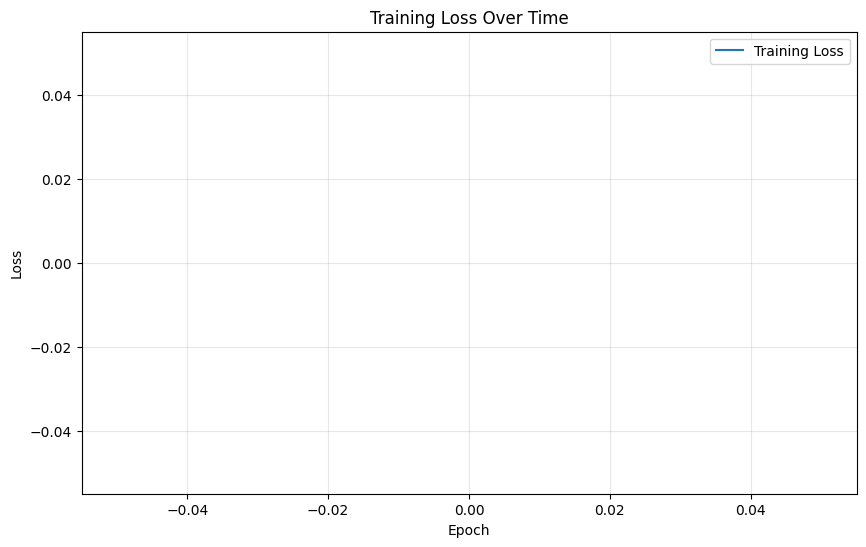

Training history saved to outputs\training_history.json



In [29]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history['epochs'], history['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / 'training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Save history
with open(OUTPUT_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to {OUTPUT_DIR / 'training_history.json'}")

## 11. Generate Final Samples

GENERATING FINAL SAMPLES - SEPARATE BY CLASS

Loading best checkpoint model...
No EMA weights found in checkpoint, using regular weights
Loaded best checkpoint from epoch 435
Best model loss: 0.002365

Disabling wandb logging for final sample generation...
Wandb unwatched successfully

GENERATING STRABISMUS SAMPLES


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


GENERATING NORMAL SAMPLES


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


VISUALIZING STRABISMUS SAMPLES


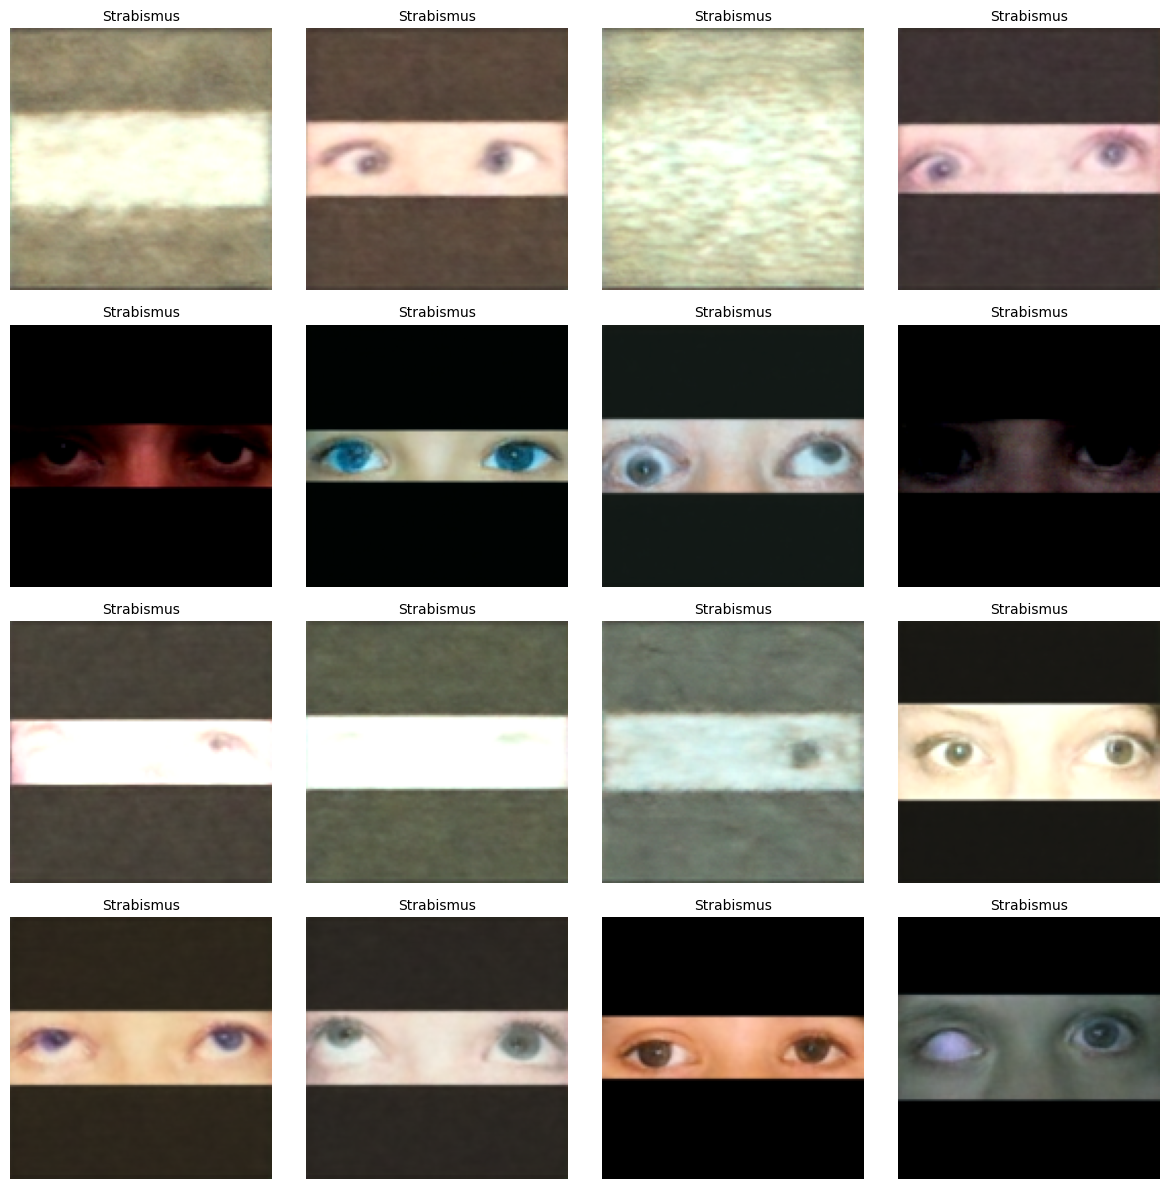

Strabismus samples saved to outputs/final_samples_strabismus.png

VISUALIZING NORMAL SAMPLES


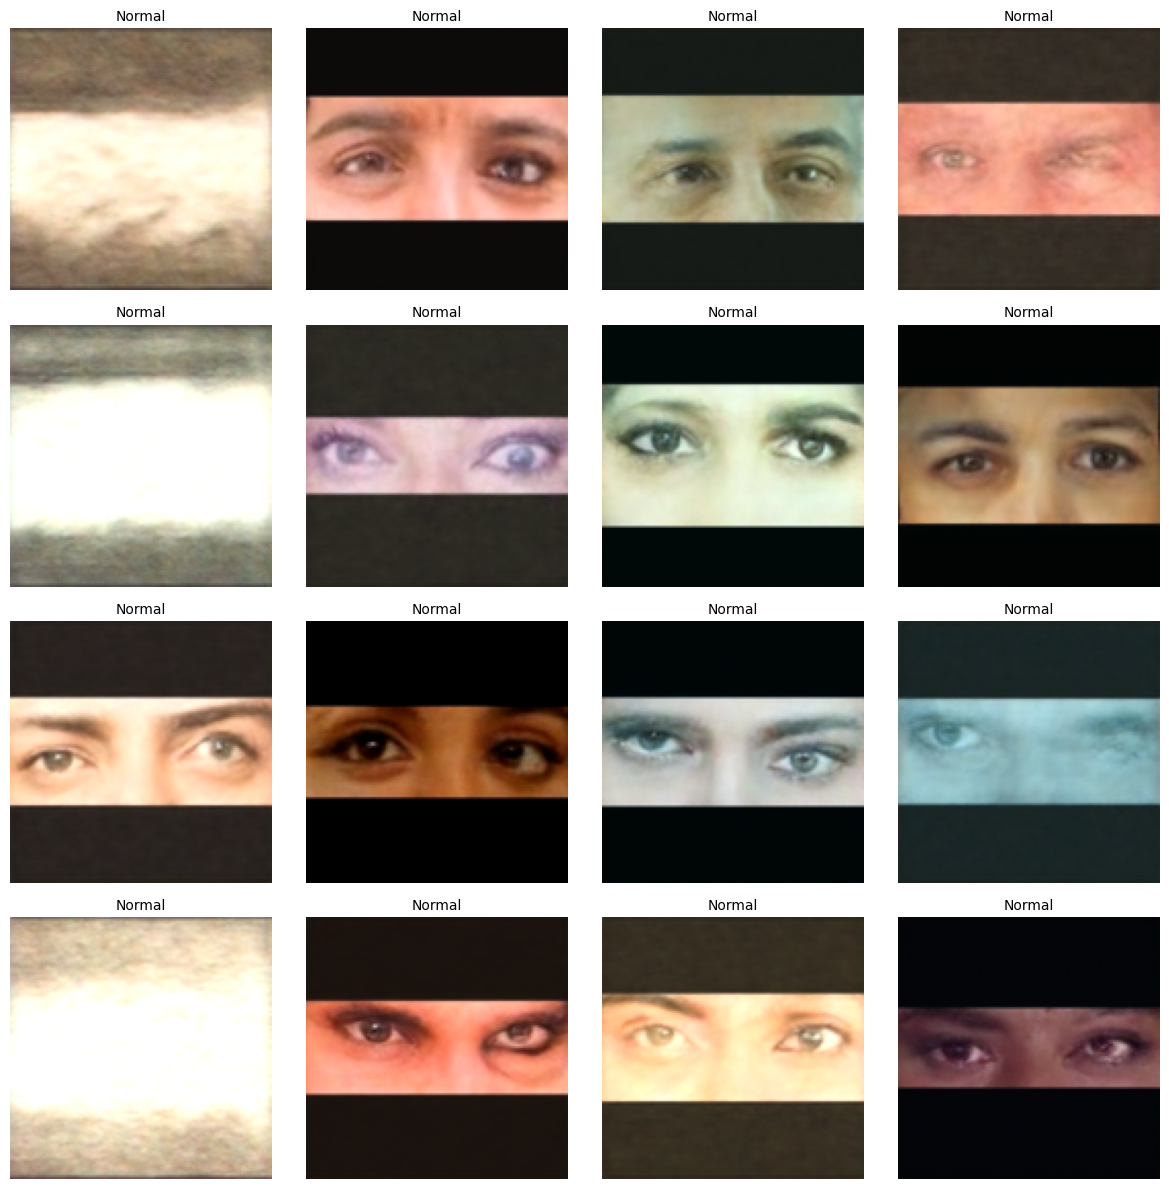

Normal samples saved to outputs/final_samples_normal.png

FINAL SAMPLES GENERATION COMPLETE
Generated separately:
  - 16 Strabismus samples -> final_samples_strabismus.png
  - 16 Normal samples -> final_samples_normal.png

Note: Wandb logging was disabled for this generation


In [30]:
# Generate final samples using the BEST checkpoint model - PER CLASS
# NOTE: Wandb logging is DISABLED for this cell to avoid interference
print('='*80)
print('GENERATING FINAL SAMPLES - SEPARATE BY CLASS')
print('='*80)
print('\nLoading best checkpoint model...')

# Load best checkpoint
best_checkpoint_path = CHECKPOINT_DIR / 'best_checkpoint.pt'

if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load EMA weights if available for better quality
    if 'ema_state_dict' in checkpoint:
        print("Loading EMA weights for better sample quality...")
        for name, param in model.named_parameters():
            if name in checkpoint['ema_state_dict']:
                param.data = checkpoint['ema_state_dict'][name]
        print("EMA weights loaded!")
    else:
        print("No EMA weights found in checkpoint, using regular weights")

    print(f"Loaded best checkpoint from epoch {checkpoint['epoch']}")
    print(f"Best model loss: {checkpoint['loss']:.6f}")
else:
    print(f"Warning: Best checkpoint not found at {best_checkpoint_path}")
    print("Using current model state instead")

# Ensure model is in eval mode
model.eval()

# COMPLETELY DISABLE WANDB for final sample generation
# Unwatch model and set a flag to prevent any logging
print("\nDisabling wandb logging for final sample generation...")
if USE_WANDB:
    try:
        wandb.unwatch(model)
        print("Wandb unwatched successfully")
    except Exception as e:
        print(f"Note: {e}")

# Temporarily disable wandb to ensure no logging
use_wandb_backup = USE_WANDB
USE_WANDB = False

# ==================== GENERATE STRABISMUS SAMPLES ====================
print(f"\n{'='*80}")
print("GENERATING STRABISMUS SAMPLES")
print('='*80)
strab_samples, strab_labels = sample_images(
    model, scheduler, num_samples=16,
    classes=[0] * 16,  # All strabismus
    device=device
)

# ==================== GENERATE NORMAL SAMPLES ====================
print(f"\n{'='*80}")
print("GENERATING NORMAL SAMPLES")
print('='*80)
normal_samples, normal_labels = sample_images(
    model, scheduler, num_samples=16,
    classes=[1] * 16,  # All normal
    device=device
)

# Restore USE_WANDB flag
USE_WANDB = use_wandb_backup

# ==================== VISUALIZE STRABISMUS ====================
print(f"\n{'='*80}")
print("VISUALIZING STRABISMUS SAMPLES")
print('='*80)
fig1, axes1 = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    row = i // 4
    col = i % 4
    img = (strab_samples[i] + 1) / 2
    img = torch.clamp(img, 0, 1)
    axes1[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes1[row, col].set_title('Strabismus', fontsize=10)
    axes1[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_samples_strabismus.png', dpi=150, bbox_inches='tight')
plt.show()
print("Strabismus samples saved to outputs/final_samples_strabismus.png")

# ==================== VISUALIZE NORMAL ====================
print(f"\n{'='*80}")
print("VISUALIZING NORMAL SAMPLES")
print('='*80)
fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    row = i // 4
    col = i % 4
    img = (normal_samples[i] + 1) / 2
    img = torch.clamp(img, 0, 1)
    axes2[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes2[row, col].set_title('Normal', fontsize=10)
    axes2[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_samples_normal.png', dpi=150, bbox_inches='tight')
plt.show()
print("Normal samples saved to outputs/final_samples_normal.png")

print(f"\n{'='*80}")
print("FINAL SAMPLES GENERATION COMPLETE")
print('='*80)
print("Generated separately:")
print("  - 16 Strabismus samples -> final_samples_strabismus.png")
print("  - 16 Normal samples -> final_samples_normal.png")
print("\nNote: Wandb logging was disabled for this generation")

## 12. Load Checkpoint and Continue Training (Optional)

In [31]:
# # Load checkpoint and continue training (Optional)

# # By default, load the BEST checkpoint
# checkpoint_path = CHECKPOINT_DIR / "best_checkpoint.pt"

# # Alternative: Load a specific epoch
# # checkpoint_path = CHECKPOINT_DIR / "checkpoint_epoch_0100.pt"

# # Check if checkpoint exists
# if checkpoint_path.exists():
#     print(f"Loading checkpoint from: {checkpoint_path}")
#     checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     loaded_loss = checkpoint['loss']

#     print(f"\n✓ Checkpoint loaded successfully!")
#     print(f"  Epoch: {checkpoint['epoch']}")
#     print(f"  Loss: {loaded_loss:.6f}")
#     print(f"\nTo continue training:")
#     print(f"  - Update EPOCHS to your target (e.g., {checkpoint['epoch'] + 100})")
#     print(f"  - Run the training loop cell again")
#     print(f"  - Training will resume from epoch {start_epoch}")
# else:
#     print(f"✗ Checkpoint not found at: {checkpoint_path}")
#     print(f"\nAvailable checkpoints:")
#     checkpoints = sorted(CHECKPOINT_DIR.glob("*.pt"))
#     if checkpoints:
#         for cp in checkpoints:
#             print(f"  - {cp.name}")
#     else:
#         print(f"  No checkpoints found in {CHECKPOINT_DIR}")
#     print(f"\nTrain the model first, or specify a different checkpoint path.")

## 13. Utilities - Sample Specific Classes

In [32]:
def generate_class_samples(model, scheduler, class_label, num_samples=16, device='cuda'):
    """
    Generate samples for a specific class.
    
    Args:
        class_label: 0 for Strabismus, 1 for Normal
        num_samples: Number of samples to generate
    """
    class_names = {0: 'Strabismus', 1: 'Normal'}
    
    print(f"Generating {num_samples} {class_names[class_label]} samples...")
    
    samples, labels = sample_images(
        model, scheduler,
        num_samples=num_samples,
        classes=[class_label] * num_samples,
        device=device
    )
    
    # Visualize
    samples_denorm = (samples + 1) / 2
    samples_denorm = torch.clamp(samples_denorm, 0, 1)
    
    grid = make_grid(samples_denorm, nrow=4, padding=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Generated {class_names[class_label]} Samples")
    plt.axis('off')
    plt.show()
    
    return samples, labels

# Example: Generate 16 strabismus samples
# strab_samples, _ = generate_class_samples(model, scheduler, class_label=0, num_samples=16)

# Example: Generate 16 normal samples
# normal_samples, _ = generate_class_samples(model, scheduler, class_label=1, num_samples=16)

## 14. Export Model for Inference

In [33]:
# # Save final model
# final_model_path = OUTPUT_DIR / 'final_model.pt'
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': {
#         'img_size': IMG_SIZE,
#         'num_classes': NUM_CLASSES,
#         'channels': CHANNELS,
#         'timesteps': TIMESTEPS,
#         'beta_start': BETA_START,
#         'beta_end': BETA_END,
#     }
# }, final_model_path)

# print(f"Final model saved to {final_model_path}")
# print(f"\nTo load this model later:")
# print(f"checkpoint = torch.load('{final_model_path}')")
# print(f"model.load_state_dict(checkpoint['model_state_dict'])")

## 15. Evaluation Metrics

Evaluate generated samples using quantitative metrics:
- **PSNR**: Peak Signal-to-Noise Ratio (higher is better)
- **SSIM**: Structural Similarity Index (0-1, higher is better)
- **IS**: Inception Score (higher is better, measures quality and diversity)
- **FID**: Fréchet Inception Distance (lower is better, measures similarity to real data)

In [15]:
# Import evaluation libraries
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import scipy.linalg
from torch_fidelity import calculate_metrics

# Inception v3 for IS and FID
from torchvision.models import inception_v3, Inception_V3_Weights


class EvaluationMetrics:
    """
    Comprehensive evaluation metrics for generated images.
    """
    def __init__(self, device='cuda'):
        self.device = device

        # Load pre-trained Inception v3 for IS and FID
        print("Loading Inception v3 model for IS and FID...")
        self.inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.inception_model = self.inception_model.to(device)
        self.inception_model.eval()
        print("Inception v3 loaded successfully!")

    @staticmethod
    def calculate_psnr(real_images, generated_images):
        """
        Calculate Peak Signal-to-Noise Ratio between real and generated images.
        Higher is better (typically 20-50 dB for good quality).

        Args:
            real_images: torch.Tensor [N, C, H, W] in range [0, 1]
            generated_images: torch.Tensor [N, C, H, W] in range [0, 1]
        """
        psnr_values = []

        real_np = real_images.cpu().numpy()
        gen_np = generated_images.cpu().numpy()

        for i in range(len(real_np)):
            # Convert to HWC format for skimage
            real_img = real_np[i].transpose(1, 2, 0)
            gen_img = gen_np[i].transpose(1, 2, 0)

            psnr_val = psnr(real_img, gen_img, data_range=1.0)
            psnr_values.append(psnr_val)

        return np.mean(psnr_values), np.std(psnr_values), psnr_values

    @staticmethod
    def calculate_ssim(real_images, generated_images):
        """
        Calculate Structural Similarity Index between real and generated images.
        Range [0, 1], higher is better (>0.8 is good).

        Args:
            real_images: torch.Tensor [N, C, H, W] in range [0, 1]
            generated_images: torch.Tensor [N, C, H, W] in range [0, 1]
        """
        ssim_values = []

        real_np = real_images.cpu().numpy()
        gen_np = generated_images.cpu().numpy()

        for i in range(len(real_np)):
            # Convert to HWC format for skimage
            real_img = real_np[i].transpose(1, 2, 0)
            gen_img = gen_np[i].transpose(1, 2, 0)

            ssim_val = ssim(real_img, gen_img, data_range=1.0, channel_axis=2)
            ssim_values.append(ssim_val)

        return np.mean(ssim_values), np.std(ssim_values), ssim_values

    def save_images_for_fid(self, images, save_dir, prefix='img'):
        """
        Save images to disk for FID calculation.

        Args:
            images: torch.Tensor [N, C, H, W] in range [0, 1]
            save_dir: Path to save directory
            prefix: Prefix for image filenames
        """
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        for i, img in enumerate(images):
            # Convert to PIL
            img_pil = transforms.ToPILImage()(img.cpu())
            img_pil.save(save_dir / f"{prefix}_{i:04d}.png")

    def calculate_inception_score(self, generated_images, splits=10):
        """
        Calculate Inception Score for generated images.
        Higher is better (typical range: 1-20+, >5 is decent).

        Args:
            generated_images: torch.Tensor [N, C, H, W] in range [0, 1]
            splits: Number of splits for calculating IS
        """
        # Save generated images to temporary directory
        temp_dir = EVAL_DIR / 'temp_is'
        temp_dir.mkdir(parents=True, exist_ok=True)

        self.save_images_for_fid(generated_images, temp_dir, prefix='gen')

        # Calculate IS using torch-fidelity
        metrics = calculate_metrics(
            input1=str(temp_dir),
            isc=True,
            isc_splits=splits,
            batch_size=32,
            cuda=torch.cuda.is_available()
        )

        # Clean up
        import shutil
        shutil.rmtree(temp_dir)

        return metrics['inception_score_mean'], metrics['inception_score_std']

    def calculate_fid(self, real_images, generated_images):
        """
        Calculate Fréchet Inception Distance between real and generated images.
        Lower is better (0 is perfect, <50 is good, <100 is acceptable).

        Args:
            real_images: torch.Tensor [N, C, H, W] in range [0, 1]
            generated_images: torch.Tensor [N, C, H, W] in range [0, 1]
        """
        # Save images to temporary directories
        real_dir = EVAL_DIR / 'temp_fid_real'
        gen_dir = EVAL_DIR / 'temp_fid_gen'

        self.save_images_for_fid(real_images, real_dir, prefix='real')
        self.save_images_for_fid(generated_images, gen_dir, prefix='gen')

        # Calculate FID using torch-fidelity
        metrics = calculate_metrics(
            input1=str(gen_dir),
            input2=str(real_dir),
            fid=True,
            batch_size=32,
            cuda=torch.cuda.is_available()
        )

        # Clean up
        import shutil
        shutil.rmtree(real_dir)
        shutil.rmtree(gen_dir)

        return metrics['frechet_inception_distance']


def evaluate_model(model, scheduler, dataloader, num_samples=100, device='cuda'):
    """
    Comprehensive evaluation of the model.

    Args:
        model: Trained DDPM model
        scheduler: DDPM scheduler
        dataloader: DataLoader for real images
        num_samples: Number of samples to generate for evaluation
        device: Device to use
    """
    print("=" * 80)
    print("Model Evaluation")
    print("=" * 80)
    print(f"Generating {num_samples} samples for evaluation...")

    # Initialize metrics
    evaluator = EvaluationMetrics(device=device)

    # Generate samples for each class
    num_per_class = num_samples // 2

    # Generate strabismus samples
    strab_samples, _ = sample_images(
        model, scheduler,
        num_samples=num_per_class,
        classes=[0] * num_per_class,
        device=device
    )

    # Generate normal samples
    normal_samples, _ = sample_images(
        model, scheduler,
        num_samples=num_per_class,
        classes=[1] * num_per_class,
        device=device
    )

    # Combine generated samples
    generated_samples = torch.cat([strab_samples, normal_samples], dim=0)

    # Denormalize to [0, 1] range
    generated_samples = (generated_samples + 1) / 2
    generated_samples = torch.clamp(generated_samples, 0, 1)

    # Get real images from dataloader
    print("Collecting real images from dataset...")
    real_images_list = []
    for images, _ in dataloader:
        real_images_list.append(images)
        if len(real_images_list) * images.size(0) >= num_samples:
            break

    real_images = torch.cat(real_images_list, dim=0)[:num_samples]
    real_images = (real_images + 1) / 2  # Denormalize
    real_images = torch.clamp(real_images, 0, 1)

    print(f"\nReal images: {real_images.shape}")
    print(f"Generated images: {generated_samples.shape}")

    # Calculate metrics
    results = {}

    # PSNR
    print("\nCalculating PSNR...")
    psnr_mean, psnr_std, _ = EvaluationMetrics.calculate_psnr(real_images, generated_samples)
    results['psnr_mean'] = float(psnr_mean)
    results['psnr_std'] = float(psnr_std)
    print(f"  PSNR: {psnr_mean:.2f} ± {psnr_std:.2f} dB")

    # SSIM
    print("Calculating SSIM...")
    ssim_mean, ssim_std, _ = EvaluationMetrics.calculate_ssim(real_images, generated_samples)
    results['ssim_mean'] = float(ssim_mean)
    results['ssim_std'] = float(ssim_std)
    print(f"  SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")

    # Inception Score
    print("Calculating Inception Score...")
    is_mean, is_std = evaluator.calculate_inception_score(generated_samples)
    results['inception_score_mean'] = float(is_mean)
    results['inception_score_std'] = float(is_std)
    print(f"  IS: {is_mean:.2f} ± {is_std:.2f}")

    # FID
    print("Calculating FID...")
    fid_score = evaluator.calculate_fid(real_images, generated_samples)
    results['fid'] = float(fid_score)
    print(f"  FID: {fid_score:.2f}")

    # Summary
    print("\n" + "=" * 80)
    print("Evaluation Summary")
    print("=" * 80)
    print(f"PSNR:             {psnr_mean:.2f} ± {psnr_std:.2f} dB  (higher is better)")
    print(f"SSIM:             {ssim_mean:.4f} ± {ssim_std:.4f}       (closer to 1 is better)")
    print(f"Inception Score:  {is_mean:.2f} ± {is_std:.2f}        (higher is better)")
    print(f"FID:              {fid_score:.2f}              (lower is better)")
    print("=" * 80)

    # Log to wandb if active
    if USE_WANDB and wandb.run is not None:
        wandb.log({
            "eval/psnr_mean": float(psnr_mean),
            "eval/psnr_std": float(psnr_std),
            "eval/ssim_mean": float(ssim_mean),
            "eval/ssim_std": float(ssim_std),
            "eval/inception_score_mean": float(is_mean),
            "eval/inception_score_std": float(is_std),
            "eval/fid": float(fid_score)
        })

    # Save results
    results_file = EVAL_DIR / 'evaluation_results.json'
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to: {results_file}")

    return results


print("Evaluation functions loaded successfully!")

Evaluation functions loaded successfully!


In [ ]:
# # Run comprehensive evaluation using the BEST checkpoint model
# # Generates samples and compares against real data using PSNR, SSIM, IS, and FID

# print('Loading best checkpoint for evaluation...')

# # Load best checkpoint
# # best_checkpoint_path = CHECKPOINT_DIR / 'best_checkpoint.pt'
# best_checkpoint_path = CHECKPOINT_DIR / 'checkpoint_epoch_1000.pt'

# if best_checkpoint_path.exists():
#     checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
#     model.load_state_dict(checkpoint['model_state_dict'])

#     # Load EMA weights if available for better quality
#     if 'ema_state_dict' in checkpoint:
#         print("Loading EMA weights for better evaluation quality...")
#         for name, param in model.named_parameters():
#             if name in checkpoint['ema_state_dict']:
#                 param.data = checkpoint['ema_state_dict'][name]
#         print("EMA weights loaded!")
#     else:
#         print("No EMA weights found in checkpoint, using regular weights")
#     print(f"Loaded best checkpoint from epoch {checkpoint['epoch']}")
#     print(f"Best model loss: {checkpoint['loss']:.6f}")
# else:
#     print(f"Warning: Best checkpoint not found at {best_checkpoint_path}")
#     print("Using current model state instead")

# # Run evaluation
# results = evaluate_model(
#     model=model,
#     scheduler=scheduler,
#     dataloader=dataloader,
#     num_samples=100,  # Adjust based on GPU memory
#     device=device
# )

Loading best checkpoint for evaluation...
Using current model state instead
Model Evaluation
Generating 100 samples for evaluation...
Loading Inception v3 model for IS and FID...
Inception v3 loaded successfully!


wandb: WARNING ConditionalUNet(
wandb: WARNING   (time_mlp): Sequential(
wandb: WARNING     (0): SinusoidalPositionEmbeddings()
wandb: WARNING     (1): Linear(in_features=256, out_features=256, bias=True)
wandb: WARNING     (2): SiLU()
wandb: WARNING     (3): Linear(in_features=256, out_features=256, bias=True)
wandb: WARNING   )
wandb: WARNING   (class_emb): Embedding(2, 128)
wandb: WARNING   (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
wandb: WARNING   (encoder): ModuleList(
wandb: WARNING     (0-1): 2 x ModuleList(
wandb: WARNING       (0): ResidualBlock(
wandb: WARNING         (conv1): Sequential(
wandb: WARNING           (0): GroupNorm(8, 64, eps=1e-05, affine=True)
wandb: WARNING           (1): SiLU()
wandb: WARNING           (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
wandb: WARNING         )
wandb: WARNING         (time_emb): Sequential(
wandb: WARNING           (0): SiLU()
wandb: WARNING           (1): Linear(in_feature

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# PER-CLASS EVALUATION - Use this for separate FID calculation
# Run this cell INSTEAD of the previous evaluation cell

print('Loading best checkpoint for PER-CLASS evaluation...')

# Load best checkpoint
best_checkpoint_path = CHECKPOINT_DIR / 'best_checkpoint.pt'

if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load EMA weights if available
    if 'ema_state_dict' in checkpoint:
        print("Loading EMA weights...")
        for name, param in model.named_parameters():
            if name in checkpoint['ema_state_dict']:
                param.data = checkpoint['ema_state_dict'][name]
        print("EMA weights loaded!")

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Loss: {checkpoint['loss']:.6f}\n")
else:
    print("Warning: Best checkpoint not found, using current model state\n")

# Initialize evaluator
evaluator = EvaluationMetrics(device=device)
model.eval()

# Collect real images BY CLASS
print("="*80)
print("COLLECTING REAL IMAGES BY CLASS")
print("="*80)

real_strabismus = []
real_normal = []
num_per_class = 50  # 50 samples per class

for images, labels in dataloader:
    for img, label in zip(images, labels):
        if label == 0 and len(real_strabismus) < num_per_class:
            real_strabismus.append(img)
        elif label == 1 and len(real_normal) < num_per_class:
            real_normal.append(img)

    if len(real_strabismus) >= num_per_class and len(real_normal) >= num_per_class:
        break

real_strabismus = torch.stack(real_strabismus[:num_per_class])
real_normal = torch.stack(real_normal[:num_per_class])

# Denormalize real images
real_strabismus = (real_strabismus + 1) / 2
real_strabismus = torch.clamp(real_strabismus, 0, 1)
real_normal = (real_normal + 1) / 2
real_normal = torch.clamp(real_normal, 0, 1)

print(f"Real Strabismus: {real_strabismus.shape}")
print(f"Real Normal: {real_normal.shape}")

# Generate STRABISMUS samples
print(f"\n{'='*80}")
print("GENERATING STRABISMUS SAMPLES")
print("="*80)
gen_strabismus, _ = sample_images(
    model, scheduler,
    num_samples=num_per_class,
    classes=[0] * num_per_class,
    device=device
)
gen_strabismus = (gen_strabismus + 1) / 2
gen_strabismus = torch.clamp(gen_strabismus, 0, 1)

# Generate NORMAL samples
print(f"\n{'='*80}")
print("GENERATING NORMAL SAMPLES")
print("="*80)
gen_normal, _ = sample_images(
    model, scheduler,
    num_samples=num_per_class,
    classes=[1] * num_per_class,
    device=device
)
gen_normal = (gen_normal + 1) / 2
gen_normal = torch.clamp(gen_normal, 0, 1)

# Calculate metrics per class
results = {}

# ========== STRABISMUS METRICS ==========
print(f"\n{'='*80}")
print("STRABISMUS CLASS EVALUATION (209 training samples)")
print("="*80)

print("Calculating PSNR...")
psnr_strab_mean, psnr_strab_std, _ = EvaluationMetrics.calculate_psnr(real_strabismus, gen_strabismus)
results['strabismus_psnr_mean'] = float(psnr_strab_mean)
results['strabismus_psnr_std'] = float(psnr_strab_std)
print(f"  PSNR: {psnr_strab_mean:.2f} ± {psnr_strab_std:.2f} dB")

print("Calculating SSIM...")
ssim_strab_mean, ssim_strab_std, _ = EvaluationMetrics.calculate_ssim(real_strabismus, gen_strabismus)
results['strabismus_ssim_mean'] = float(ssim_strab_mean)
results['strabismus_ssim_std'] = float(ssim_strab_std)
print(f"  SSIM: {ssim_strab_mean:.4f} ± {ssim_strab_std:.4f}")

print("Calculating Inception Score...")
is_strab_mean, is_strab_std = evaluator.calculate_inception_score(gen_strabismus)
results['strabismus_inception_score_mean'] = float(is_strab_mean)
results['strabismus_inception_score_std'] = float(is_strab_std)
print(f"  IS: {is_strab_mean:.2f} ± {is_strab_std:.2f}")

print("Calculating FID...")
fid_strab = evaluator.calculate_fid(real_strabismus, gen_strabismus)
results['strabismus_fid'] = float(fid_strab)
print(f"  FID: {fid_strab:.2f}")

# ========== NORMAL METRICS ==========
print(f"\n{'='*80}")
print("NORMAL CLASS EVALUATION (105 training samples)")
print("="*80)

print("Calculating PSNR...")
psnr_normal_mean, psnr_normal_std, _ = EvaluationMetrics.calculate_psnr(real_normal, gen_normal)
results['normal_psnr_mean'] = float(psnr_normal_mean)
results['normal_psnr_std'] = float(psnr_normal_std)
print(f"  PSNR: {psnr_normal_mean:.2f} ± {psnr_normal_std:.2f} dB")

print("Calculating SSIM...")
ssim_normal_mean, ssim_normal_std, _ = EvaluationMetrics.calculate_ssim(real_normal, gen_normal)
results['normal_ssim_mean'] = float(ssim_normal_mean)
results['normal_ssim_std'] = float(ssim_normal_std)
print(f"  SSIM: {ssim_normal_mean:.4f} ± {ssim_normal_std:.4f}")

print("Calculating Inception Score...")
is_normal_mean, is_normal_std = evaluator.calculate_inception_score(gen_normal)
results['normal_inception_score_mean'] = float(is_normal_mean)
results['normal_inception_score_std'] = float(is_normal_std)
print(f"  IS: {is_normal_mean:.2f} ± {is_normal_std:.2f}")

print("Calculating FID...")
fid_normal = evaluator.calculate_fid(real_normal, gen_normal)
results['normal_fid'] = float(fid_normal)
print(f"  FID: {fid_normal:.2f}")

# ========== COMBINED METRICS ==========
print(f"\n{'='*80}")
print("COMBINED METRICS")
print("="*80)

combined_real = torch.cat([real_strabismus, real_normal], dim=0)
combined_gen = torch.cat([gen_strabismus, gen_normal], dim=0)

print("Calculating combined FID...")
fid_combined = evaluator.calculate_fid(combined_real, combined_gen)
results['combined_fid'] = float(fid_combined)
print(f"  FID (Combined): {fid_combined:.2f}")

print("Calculating combined IS...")
is_combined_mean, is_combined_std = evaluator.calculate_inception_score(combined_gen)
results['combined_inception_score_mean'] = float(is_combined_mean)
results['combined_inception_score_std'] = float(is_combined_std)
print(f"  IS (Combined): {is_combined_mean:.2f} ± {is_combined_std:.2f}")

# ========== SUMMARY ==========
print(f"\n{'='*80}")
print("PER-CLASS EVALUATION SUMMARY")
print("="*80)
print(f"\nSTRABISMUS (209 training samples):")
print(f"  PSNR: {psnr_strab_mean:.2f} ± {psnr_strab_std:.2f} dB")
print(f"  SSIM: {ssim_strab_mean:.4f} ± {ssim_strab_std:.4f}")
print(f"  IS:   {is_strab_mean:.2f} ± {is_strab_std:.2f}")
print(f"  FID:  {fid_strab:.2f}")

print(f"\nNORMAL (105 training samples):")
print(f"  PSNR: {psnr_normal_mean:.2f} ± {psnr_normal_std:.2f} dB")
print(f"  SSIM: {ssim_normal_mean:.4f} ± {ssim_normal_std:.4f}")
print(f"  IS:   {is_normal_mean:.2f} ± {is_normal_std:.2f}")
print(f"  FID:  {fid_normal:.2f}")

print(f"\nCOMBINED:")
print(f"  IS:   {is_combined_mean:.2f} ± {is_combined_std:.2f}")
print(f"  FID:  {fid_combined:.2f}")

print(f"\nExpected: Strabismus FID < Normal FID (due to more training data)")
print("="*80)

# Log to wandb
if USE_WANDB and wandb.run is not None:
    wandb.log({
        "eval/strabismus_psnr": psnr_strab_mean,
        "eval/strabismus_ssim": ssim_strab_mean,
        "eval/strabismus_is": is_strab_mean,
        "eval/strabismus_fid": fid_strab,
        "eval/normal_psnr": psnr_normal_mean,
        "eval/normal_ssim": ssim_normal_mean,
        "eval/normal_is": is_normal_mean,
        "eval/normal_fid": fid_normal,
        "eval/combined_is": is_combined_mean,
        "eval/combined_fid": fid_combined
    })

# Save results
results_file = EVAL_DIR / 'evaluation_results_per_class.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\nResults saved to: {results_file}")

Loading best checkpoint for PER-CLASS evaluation...
Loaded checkpoint from epoch 435
Loss: 0.002365

Loading Inception v3 model for IS and FID...
Inception v3 loaded successfully!
COLLECTING REAL IMAGES BY CLASS
Real Strabismus: torch.Size([50, 3, 128, 128])
Real Normal: torch.Size([50, 3, 128, 128])

GENERATING STRABISMUS SAMPLES


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


GENERATING NORMAL SAMPLES


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


STRABISMUS CLASS EVALUATION (209 training samples)
Calculating PSNR...
  PSNR: 10.01 ± 4.85 dB
Calculating SSIM...
  SSIM: 0.2862 ± 0.2862
Calculating Inception Score...


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "outputs\evaluation\temp_is" with extensions png,jpg,jpeg
Found 50 samples
c:\Users\Ayman\anaconda3\envs\thesis_venv\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Inception Score: 1.9392387582425445 ± 0.359627509251955


  IS: 1.94 ± 0.36
Calculating FID...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_gen" with extensions png,jpg,jpeg
Found 50 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_real" with extensions png,jpg,jpeg
Found 50 samples
Processing samples                                                      
c:\Users\Ayman\anaconda3\envs\thesis_venv\Lib\site-packages\torch_fidelity\metric_fid.py:47: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
Frechet Inception Distance: 173.9898588039798


  FID: 173.99

NORMAL CLASS EVALUATION (105 training samples)
Calculating PSNR...
  PSNR: 10.49 ± 4.08 dB
Calculating SSIM...
  SSIM: 0.3064 ± 0.2620
Calculating Inception Score...


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "outputs\evaluation\temp_is" with extensions png,jpg,jpeg
Found 50 samples
Processing samples                                                      
Inception Score: 1.9270923648815756 ± 0.23339727133256216


  IS: 1.93 ± 0.23
Calculating FID...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_gen" with extensions png,jpg,jpeg
Found 50 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_real" with extensions png,jpg,jpeg
Found 50 samples
Processing samples                                                      
Frechet Inception Distance: 118.80299252865376


  FID: 118.80

COMBINED METRICS
Calculating combined FID...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_gen" with extensions png,jpg,jpeg
Found 100 samples
Processing samples                                                        
Extracting statistics from input 2
Looking for samples non-recursivelty in "outputs\evaluation\temp_fid_real" with extensions png,jpg,jpeg
Found 100 samples
Processing samples                                                       
Frechet Inception Distance: 135.80315154129897


  FID (Combined): 135.80
Calculating combined IS...


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "outputs\evaluation\temp_is" with extensions png,jpg,jpeg
Found 100 samples
Processing samples                                                       
Inception Score: 2.287756132486748 ± 0.32572484065253493


  IS (Combined): 2.29 ± 0.33

PER-CLASS EVALUATION SUMMARY

STRABISMUS (209 training samples):
  PSNR: 10.01 ± 4.85 dB
  SSIM: 0.2862 ± 0.2862
  IS:   1.94 ± 0.36
  FID:  173.99

NORMAL (105 training samples):
  PSNR: 10.49 ± 4.08 dB
  SSIM: 0.3064 ± 0.2620
  IS:   1.93 ± 0.23
  FID:  118.80

COMBINED:
  IS:   2.29 ± 0.33
  FID:  135.80

Expected: Strabismus FID < Normal FID (due to more training data)

Results saved to: outputs\evaluation\evaluation_results_per_class.json
